# Recognition of Yoga Postures

## Necessary libraries
We choose
[Pytorch](https://pytorch.org/)
as our framework for this project for its learning parh and It is Simple GPU installation.
And we are going to work with

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import shutil
import numpy as np
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
from shutil import copyfile
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from utils import split_data
from fastai.vision.all import get_image_files,verify_images
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.losses import categorical_crossentropy,SparseCategoricalCrossentropy
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import datetime

In [3]:
# check if CUDA is available to use GPU on the training 
train_on_gpu = tf.config.list_physical_devices('GPU')
if train_on_gpu:
    print('GPU con soporte CUDA disponible')
else:
    print('No se encontró GPU con soporte CUDA')

GPU con soporte CUDA disponible


We r going to delet images "broken"

In [4]:
images=get_image_files('../YOGA/dataset')
images
failed = verify_images(images)
failed

(#0) []

In [5]:
images=get_image_files('../YOGA/DATA')
images
failed = verify_images(images)
failed

(#0) []

In [6]:
# Define paths for the images
downdog_SRC_DIR = "data/downdog"
goddess_SRC_DIR = "data/goddess"
plank_SRC_DIR = "data/plank"
tree_SRC_DIR = "data/tree"
warrior_SRC_DIR = "data/warrior"
TRAINING_DIR = "dataset/training"
VALIDATION_DIR = "dataset/validation"
TEST_DIR = "dataset/test"
#splitting the dataset
TRAINING_DDG_DIR = os.path.join(TRAINING_DIR, "downdog/")
VALIDATION_DDG_DIR = os.path.join(VALIDATION_DIR, "downdog/")
TEST_DDG_DIR = os.path.join(TEST_DIR, "downdog/")

TRAINING_GDS_DIR = os.path.join(TRAINING_DIR, "goddess/")
VALIDATION_GDS_DIR = os.path.join(VALIDATION_DIR, "goddess/")
TEST_GDS_DIR = os.path.join(TEST_DIR, "goddess/")

TRAINING_PLANK_DIR = os.path.join(TRAINING_DIR, "plank/")
VALIDATION_PLANK_DIR = os.path.join(VALIDATION_DIR, "plank/")
TEST_PLANK_DIR = os.path.join(TEST_DIR, "plank/")

TRAINING_TREE_DIR = os.path.join(TRAINING_DIR, "tree/")
VALIDATION_TREE_DIR = os.path.join(VALIDATION_DIR, "tree/")
TEST_TREE_DIR = os.path.join(TEST_DIR, "tree/")

TRAINING_WR_DIR = os.path.join(TRAINING_DIR, "warrior/")
VALIDATION_WR_DIR = os.path.join(VALIDATION_DIR, "warrior/")
TEST_WR_DIR = os.path.join(TEST_DIR, "warrior/")
# Define proportion of images used for training
train_size = 0.8
val_size = 0.1
test_size = 0.1

split_data(downdog_SRC_DIR,
           TRAINING_DDG_DIR,
           VALIDATION_DDG_DIR,
           TEST_DDG_DIR,
           split_ratio=(train_size,val_size, test_size))

split_data(goddess_SRC_DIR,
           TRAINING_GDS_DIR,
           VALIDATION_GDS_DIR,
           TEST_GDS_DIR,
           split_ratio=(train_size,val_size, test_size))

split_data(plank_SRC_DIR,
           TRAINING_PLANK_DIR,
           VALIDATION_PLANK_DIR,
           TEST_PLANK_DIR,
           split_ratio=(train_size,val_size, test_size))

split_data(tree_SRC_DIR,
           TRAINING_TREE_DIR,
           VALIDATION_TREE_DIR,
           TEST_TREE_DIR,
           split_ratio=(train_size,val_size, test_size))
split_data(warrior_SRC_DIR,
           TRAINING_WR_DIR,
           VALIDATION_WR_DIR,
           TEST_WR_DIR,
           split_ratio=(train_size,val_size, test_size))

Splitting data completed.
Splitting data completed.
Splitting data completed.
Splitting data completed.
Splitting data completed.


In [7]:
print(f"Original Downdog directory has {len(os.listdir(downdog_SRC_DIR))} images")
print(f"Original Goddess directory has {len(os.listdir(goddess_SRC_DIR))} images")
print(f"Original Plank directory has {len(os.listdir(plank_SRC_DIR))} images")
print(f"Original Tree directory has {len(os.listdir(tree_SRC_DIR))} images")
print(f"Original Warrior directory has {len(os.listdir(warrior_SRC_DIR))} images\n")

# Training and validation splits
print(f"There are {len(os.listdir(TRAINING_DDG_DIR))} images of Dogdown for training")
print(f"There are {len(os.listdir(TRAINING_GDS_DIR))} images of Goddess for training")
print(f"There are {len(os.listdir(TRAINING_PLANK_DIR))} images of Plank for training")
print(f"There are {len(os.listdir(TRAINING_TREE_DIR))} images of Tree for training")
print(f"There are {len(os.listdir(TRAINING_WR_DIR))} images of Warrior for training\n")

print(f"There are {len(os.listdir(VALIDATION_DDG_DIR))} images of Dogdown for validation")           
print(f"There are {len(os.listdir(VALIDATION_GDS_DIR))} images of Goddess for validation")
print(f"There are {len(os.listdir(VALIDATION_PLANK_DIR))} images of Plank for validation")
print(f"There are {len(os.listdir(VALIDATION_TREE_DIR))} images of Tree for validation")
print(f"There are {len(os.listdir(VALIDATION_WR_DIR))} images of Warrior for validation\n")

print(f"There are {len(os.listdir(TEST_DDG_DIR))} images of Dogdown for test")
print(f"There are {len(os.listdir(TEST_GDS_DIR))} images of Goddess for test")
print(f"There are {len(os.listdir(TEST_PLANK_DIR))} images of Plank for test")
print(f"There are {len(os.listdir(TEST_TREE_DIR))} images of Plank for test")
print(f"There are {len(os.listdir(TEST_WR_DIR))} images of tree for test")

Original Downdog directory has 536 images
Original Goddess directory has 446 images
Original Plank directory has 380 images
Original Tree directory has 647 images
Original Warrior directory has 584 images

There are 428 images of Dogdown for training
There are 356 images of Goddess for training
There are 304 images of Plank for training
There are 517 images of Tree for training
There are 467 images of Warrior for training

There are 53 images of Dogdown for validation
There are 44 images of Goddess for validation
There are 38 images of Plank for validation
There are 64 images of Tree for validation
There are 58 images of Warrior for validation

There are 55 images of Dogdown for test
There are 46 images of Goddess for test
There are 38 images of Plank for test
There are 66 images of Plank for test
There are 59 images of tree for test


## Data


In [9]:
# Definir un generador de imágenes con transformaciones
batch_size = 16
width=224
height=224
data_generator = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.6,1.0],
    validation_split=0.20
)

train_data = data_generator.flow_from_directory(
    TRAINING_DIR,
    target_size=(width, height),
    batch_size=batch_size,
    class_mode='sparse',  
    color_mode="rgb"
)

validation_data = data_generator.flow_from_directory(
    VALIDATION_DIR,
    target_size=(width, height),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='sparse',
)

test_data = data_generator.flow_from_directory(
    TEST_DIR,
    target_size=(width, height),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='sparse',
)


Found 2066 images belonging to 5 classes.
Found 257 images belonging to 5 classes.
Found 264 images belonging to 5 classes.


Observemos una nuestro train data en lote 

['downdog', 'goddess', 'plank', 'tree', 'warrior']


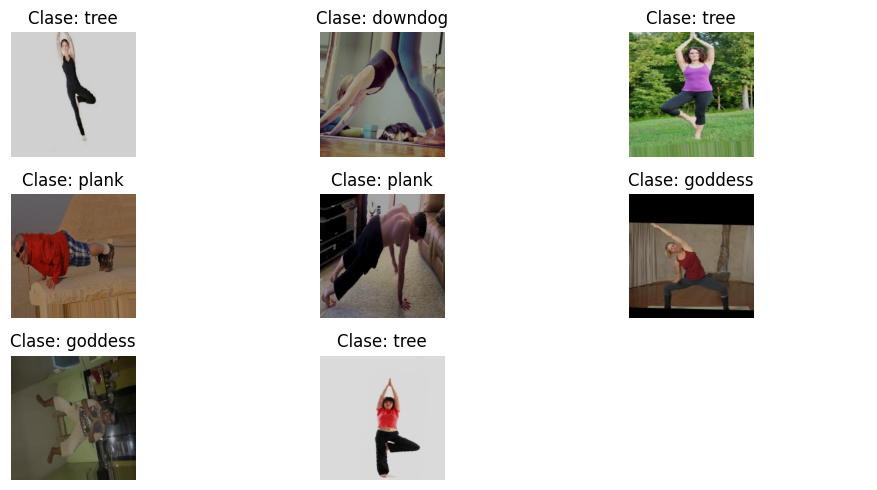

In [10]:
# Obtener un lote de imágenes y etiquetas del generador de datos
images, labels = next(train_data)

# Etiquetas de las clases (nombre de las carpetas)
class_labels = list(train_data.class_indices.keys())
print(class_labels)
# Configurar subplots
num_images = 8
num_cols = 3 # Número de columnas en la cuadrícula
num_rows = (num_images + num_cols - 1) // num_cols  # Calcular el número de filas necesarias

# Crear una cuadrícula de subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 5))

# Iterar a través de las imágenes y subplots
for i, ax in enumerate(axes.flatten()):
    if i < num_images:
        image = images[i]
        label = class_labels[int(labels[i])]
        
        ax.imshow(image)
        ax.set_title(f"Clase: {label}")
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
class Net(models.Model):
    def __init__(self):
        super(Net, self).__init__()

        # Primera serie de capas convolucionales y pooling
        self.conv1_1 = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')
        self.conv1_2 = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')
        self.bn1 = layers.BatchNormalization()
        self.pool1 = layers.MaxPooling2D(pool_size=(2, 2))

        # Segunda serie de capas convolucionales y pooling
        self.conv2_1 = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')
        self.conv2_2 = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')
        self.bn2 = layers.BatchNormalization()
        self.pool2 = layers.MaxPooling2D(pool_size=(2, 2))

        # Tercera serie de capas convolucionales y pooling
        self.conv3_1 = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')
        self.conv3_2 = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')
        self.bn3 = layers.BatchNormalization()
        self.pool3 = layers.MaxPooling2D(pool_size=(2, 2))

        # Cuarta serie de capas convolucionales y pooling
        self.conv4_1 = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')
        self.conv4_2 = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')
        self.bn4 = layers.BatchNormalization()
        self.pool4 = layers.MaxPooling2D(pool_size=(2, 2))

        self.flatten = layers.Flatten()

        # Capas densas
        self.fc1 = layers.Dense(512, activation='relu')
        self.dropout1 = layers.Dropout(0.3)
        self.fc2 = layers.Dense(256, activation='relu')
        self.dropout2 = layers.Dropout(0.3)
        self.fc3 = layers.Dense(128, activation='relu')
        self.dropout3 = layers.Dropout(0.3)
        self.fc4 = layers.Dense(5, activation='softmax')

    def call(self, x):
        x = self.pool1(self.bn1(self.conv1_2(self.conv1_1(x))))
        x = self.pool2(self.bn2(self.conv2_2(self.conv2_1(x))))
        x = self.pool3(self.bn3(self.conv3_2(self.conv3_1(x))))
        x = self.pool4(self.bn4(self.conv4_2(self.conv4_1(x))))
        x = self.flatten(x)
        x = self.dropout1(self.fc1(x))
        x = self.dropout2(self.fc2(x))
        x = self.dropout3(self.fc3(x))
        x = self.fc4(x)
        return x



In [ ]:
class ImprovedNet(models.Model):
    def __init__(self):
        super(ImprovedNet, self).__init__()

        # Primera serie de capas convolucionales y pooling
        self.conv1_1 = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')
        self.conv1_2 = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')
        self.dropout1 = layers.Dropout(0.2)
        self.pool1 = layers.MaxPooling2D(pool_size=(2, 2))

        # Segunda serie de capas convolucionales y pooling
        self.conv2_1 = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')
        self.conv2_2 = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')
        self.dropout2 = layers.Dropout(0.2)
        self.pool2 = layers.MaxPooling2D(pool_size=(2, 2))

        # Tercera serie de capas convolucionales y pooling
        self.conv3_1 = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')
        self.conv3_2 = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')
        self.dropout3 = layers.Dropout(0.2)
        self.pool3 = layers.MaxPooling2D(pool_size=(2, 2))

        # Cuarta serie de capas convolucionales y pooling
        self.conv4_1 = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')
        self.conv4_2 = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')
        self.dropout4 = layers.Dropout(0.2)
        self.pool4 = layers.MaxPooling2D(pool_size=(2, 2))

        # Quinta serie de capas convolucionales y pooling
        self.conv5_1 = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')
        self.conv5_2 = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')
        self.dropout5 = layers.Dropout(0.2)
        self.pool5 = layers.MaxPooling2D(pool_size=(2, 2))

        self.flatten = layers.Flatten()

        # Capas densas
        self.fc1 = layers.Dense(64, activation='relu')
        self.fc_dropout1 = layers.Dropout(0.3)
        self.fc2 = layers.Dense(32, activation='relu')
        self.fc_dropout2 = layers.Dropout(0.3)
        self.fc3 = layers.Dense(5, activation='softmax')

    def call(self, x):
        x = self.pool1(self.dropout1(self.conv1_2(self.conv1_1(x))))
        x = self.pool2(self.dropout2(self.conv2_2(self.conv2_1(x))))
        x = self.pool3(self.dropout3(self.conv3_2(self.conv3_1(x))))
        x = self.pool4(self.dropout4(self.conv4_2(self.conv4_1(x))))
        x = self.pool5(self.dropout5(self.conv5_2(self.conv5_1(x))))
        x = self.flatten(x)
        x = self.fc_dropout1(self.fc1(x))
        x = self.fc_dropout2(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:

class TransferNet(models.Model):
    def __init__(self, base_model_weights=None):
        super(TransferNet, self).__init__()
        self.base_model = tf.keras.applications.VGG16(include_top=False, weights=base_model_weights, input_shape=(250, 250, 3))
        self.flatten = layers.Flatten()
        # Capas densas
        self.fc1 = layers.Dense(64, activation='relu')
        self.fc_dropout1 = layers.Dropout(0.3)
        self.fc2 = layers.Dense(32, activation='relu')
        self.fc_dropout2 = layers.Dropout(0.3)
        self.fc3 = layers.Dense(5, activation='softmax')

    def call(self, x):
        x = self.base_model(x)
        x = self.flatten(x)
        x = self.fc_dropout1(self.fc1(x))
        x = self.fc_dropout2(self.fc2(x))
        x = self.fc3(x)
        return x
    def get_config(self):
        return {"base_model_name": "VGG16"}


    @classmethod
    def from_config(cls, config):
        if config["base_model_name"] == "VGG16":
            return cls(base_model_weights="imagenet")




In [ ]:
class ModifiedTransferNetVGG(models.Model):
    def __init__(self, base_model_weights=None):
        super(ModifiedTransferNetVGG, self).__init__()
        self.base_model = tf.keras.applications.VGG16(include_top=False, weights=base_model_weights, input_shape=(250, 250, 3))
        self.flatten = layers.Flatten()
        
        # Capa convolucional adicional
        self.extra_conv = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')
        self.extra_pool = layers.MaxPooling2D(pool_size=(2, 2))
        self.extra_dropout = layers.Dropout(0.3)
        
        # Capas densas
        self.fc1 = layers.Dense(128, activation='relu')
        self.fc_dropout1 = layers.Dropout(0.4)
        self.fc2 = layers.Dense(64, activation='relu')
        self.fc_dropout2 = layers.Dropout(0.4)
        self.fc3 = layers.Dense(32, activation='relu')
        self.fc_dropout3 = layers.Dropout(0.4)
        self.fc4 = layers.Dense(5, activation='softmax')

    def call(self, x):
        x = self.base_model(x)
        x = self.extra_dropout(self.extra_pool(self.extra_conv(x)))
        x = self.flatten(x)
        x = self.fc_dropout1(self.fc1(x))
        x = self.fc_dropout2(self.fc2(x))
        x = self.fc_dropout3(self.fc3(x))
        x = self.fc4(x)
        return x


In [ ]:
class ModifiedTransferNetResNet(models.Model):
    def __init__(self, base_model_weights=None):
        super(ModifiedTransferNetResNet, self).__init__()
        self.base_model = tf.keras.applications.ResNet50(include_top=False, weights=base_model_weights, input_shape=(224, 224, 3))
        self.flatten = layers.Flatten()
        
        # Capas densas
        self.fc1 = layers.Dense(4096, activation='relu')
        self.fc_dropout1 = layers.Dropout(0.2)
        self.fc2 = layers.Dense(1024, activation='relu')
        self.fc_dropout2 = layers.Dropout(0.3)
        self.fc3 = layers.Dense(64, activation='relu')
        self.fc_dropout3 = layers.Dropout(0.4)
        self.fc4 = layers.Dense(5, activation='softmax')

    def call(self, x):
        x = self.base_model(x)
        x = self.flatten(x)
        x = self.fc_dropout1(self.fc1(x))
        x = self.fc_dropout2(self.fc2(x))
        x = self.fc_dropout3(self.fc3(x))
        x = self.fc4(x)
        return x


In [ ]:
def VGG19(input_shape=(224, 224, 3), num_classes=5):
    model = Sequential()

    # Primera sección: 2x Conv -> MaxPool
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Segunda sección: 2x Conv -> MaxPool
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Tercera sección: 4x Conv -> MaxPool
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Cuarta sección: 4x Conv -> MaxPool
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Quinta sección: 4x Conv -> MaxPool
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Sección fully connected
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(1024, activation='relu'))#paso mas lento
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    return model



In [47]:
class TransferNetVGG19(models.Model):
    def __init__(self, base_model_weights=None):
        super(TransferNetVGG19, self).__init__()
        self.base_model = tf.keras.applications.VGG19(include_top=False, weights=base_model_weights, input_shape=(224, 224, 3))
        for layer in self.base_model.layers:
            layer.trainable = False  # Freeze VGG19 layers initially
        self.flatten = layers.Flatten()
        
        # Simplified dense layers
        self.fc1 = layers.Dense(4096, activation='relu')
        self.fc2 = layers.Dense(4096, activation='relu')
        self.fc3 = layers.Dense(1024, activation='relu')
        self.fc_dropout1 = layers.Dropout(0.3)
        self.fc4 = layers.Dense(32, activation='relu')
        self.fc_dropout2 = layers.Dropout(0.3)
        self.fc5 = layers.Dense(5, activation='softmax')

    def call(self, x):
        x = self.base_model(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc_dropout1(x)
        x = self.fc3(x)
        x = self.fc_dropout2(x)
        x = self.fc4(x)
        x = self.fc5(x)
        return x

    def get_config(self):
        return {"base_model_name": "VGG19"}

    @classmethod
    def from_config(cls, config):
        if config["base_model_name"] == "VGG19":
            return cls(base_model_weights="imagenet")


In [48]:
#model = Net()
#model = ImprovedNet()
#model = TransferNet()
#model = ModifiedTransferNetResNet()
#model= VGG19(input_shape=(250, 250, 3), num_classes=5)
model = TransferNetVGG19()

In [49]:
criterion = SparseCategoricalCrossentropy()
optimizer = Adam(learning_rate=0.0004)
EPOCHS=20

In [24]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)


In [51]:
model.compile(optimizer=optimizer, 
              loss=SparseCategoricalCrossentropy(), 
              metrics=['accuracy'])

In [26]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=0, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint('checkpoint', monitor='val_loss', verbose=0, save_best_only=True)


In [27]:
STEP_SIZE_TRAIN=train_data.n//train_data.batch_size
STEP_SIZE_VALID=validation_data.n//validation_data.batch_size
STEP_SIZE_TEST=test_data.n//test_data.batch_size
STEP_SIZE_TRAIN

129

In [28]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks = [early_stopping, checkpoint,lr_schedule, tensorboard_callback]


In [52]:
history =model.fit(train_data,
    validation_data=validation_data,
     validation_steps=STEP_SIZE_VALID,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/20
 45/130 [=========>....................] - ETA: 1:28 - loss: 1.6378 - accuracy: 0.2431

/Users/johanjairgilcesreyes/miniconda3/envs/myenv/lib/python3.8/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


130/130 [==============================] - 185s 1s/step - loss: 1.6638 - accuracy: 0.2289 - val_loss: 1.6264 - val_accuracy: 0.2500 - lr: 4.0000e-04
Epoch 2/20
130/130 [==============================] - 187s 1s/step - loss: 1.6900 - accuracy: 0.2028 - val_loss: 1.6223 - val_accuracy: 0.1719 - lr: 4.0000e-04
Epoch 3/20
130/130 [==============================] - 186s 1s/step - loss: 1.6848 - accuracy: 0.2202 - val_loss: 1.6269 - val_accuracy: 0.2227 - lr: 4.0000e-04
Epoch 4/20
130/130 [==============================] - 184s 1s/step - loss: 1.6993 - accuracy: 0.2285 - val_loss: 1.6156 - val_accuracy: 0.2266 - lr: 4.0000e-04
Epoch 5/20
130/130 [==============================] - 178s 1s/step - loss: 1.7050 - accuracy: 0.2207 - val_loss: 1.6303 - val_accuracy: 0.2266 - lr: 4.0000e-04
Epoch 6/20
130/130 [==============================] - ETA: 0s - loss: 1.6929 - accuracy: 0.2115

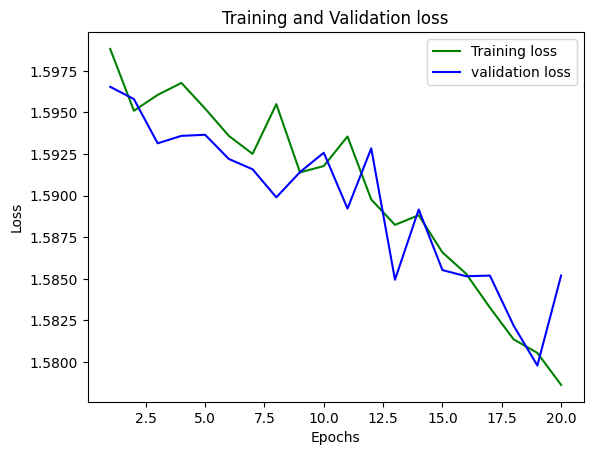

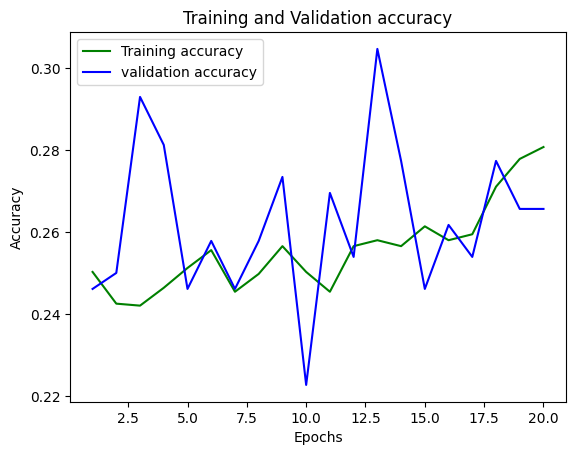

In [38]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,EPOCHS+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
    
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,EPOCHS+1)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



In [39]:
model.summary()

Model: "transfer_net_vgg19_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         multiple                  0         
                                                                 
 dense_3 (Dense)             multiple                  25691136  
                                                                 
 dropout_2 (Dropout)         multiple                  0         
                                                                 
 dense_4 (Dense)             multiple                  524800    
                                                                 
 dropout_3 (Dropout)         multiple                  0         
                                                                 
 dense_5 (Dense)             multiple         

In [40]:
model.save_weights('yoga_vgg19.h5')

In [41]:
#for gradio
def predict_image(img):
    # Redimensionar y preprocesar la imagen
    img = img.reshape(1, width, height, 3)
    img = img / 255.0

    # Hacer la predicción
    predictions = model.predict(img)
    predicted_class = np.argmax(predictions)

    # Obtener el nombre de la clase
    class_names = list(train_data.class_indices.keys())
    return class_names[predicted_class]


### Resultados del modelo

17/17 [==============================] - 14s 853ms/step


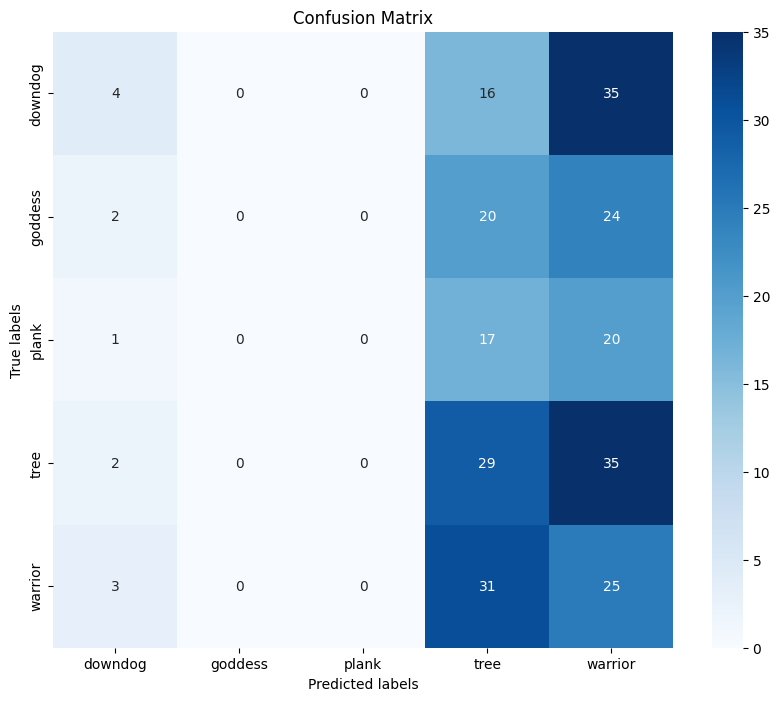

In [42]:
# Obtener las predicciones del modelo
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())

# Calcular la matriz de confusión
confusion = confusion_matrix(true_classes, predicted_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [43]:


# 1. Predice las etiquetas de tus datos de prueba.
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)

# 2. Obtén las etiquetas verdaderas de tus datos de prueba.
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())

# 3. Usa `classification_report` para obtener el informe.
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)


17/17 [==============================] - 12s 743ms/step
              precision    recall  f1-score   support

     downdog       0.29      0.04      0.06        55
     goddess       0.00      0.00      0.00        46
       plank       0.00      0.00      0.00        38
        tree       0.28      0.44      0.34        66
     warrior       0.22      0.58      0.32        59

    accuracy                           0.25       264
   macro avg       0.16      0.21      0.15       264
weighted avg       0.18      0.25      0.17       264



/Users/johanjairgilcesreyes/miniconda3/envs/myenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/johanjairgilcesreyes/miniconda3/envs/myenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/johanjairgilcesreyes/miniconda3/envs/myenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [44]:
# Asegúrate de que el modelo ha sido llamado al menos una vez
dummy_input = np.random.random((1, width, height, 3))
_ = model(dummy_input)


## Fine tuning

In [45]:
for layer in base_model.layers[-5:]:
    layer.trainable = True

# Compilar el modelo con un learning rate muy bajo
optimizer_fine_tuning = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer_fine_tuning, 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics=['accuracy'])

# Continuar el entrenamiento
history =model.fit(train_data,
        steps_per_epoch=STEP_SIZE_TRAIN,
        validation_data=validation_data,
        validation_steps=STEP_SIZE_VALID,
        epochs=EPOCHS,
        callbacks=callbacks
)

NameError: name 'base_model' is not defined

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,EPOCHS+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
    
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,EPOCHS+1)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



## Searching best HiperParameters


In [ ]:
from kerastuner import HyperModel

class TransferNetTuner(HyperModel):
    def __init__(self, base_model_weights=None):
        self.base_model_weights = base_model_weights


In [ ]:
def build_model(hp):
        model = TransferNet(base_model_weights='imagenet')
        
       # Hiperparámetro para el learning rate
        lr = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3)

        # Hiperparámetro para el optimizador
        optimizer = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])

        # Compilación del modelo
        if optimizer == 'adam':
                opt = tf.keras.optimizers.legacy.Adam(learning_rate=lr)
        elif optimizer == 'sgd':
                opt = tf.keras.optimizers.SGD(learning_rate=lr)
        elif optimizer == 'rmsprop':
                opt = tf.keras.optimizers.RMSprop(learning_rate=lr)

        model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',       # Métrica a monitorizar. En este caso, es la pérdida de validación.
    patience=10,              # Número de épocas sin mejora después de las cuales se detiene el entrenamiento.
    verbose=1,                # Para imprimir mensajes.
    restore_best_weights=True # Restaura los pesos del modelo al mejor punto encontrado durante el entrenamiento.
)

In [ ]:
from kerastuner.tuners import RandomSearch

# Usar solo la mitad de los datos para acelerar la búsqueda

half_steps_per_epoch = int(STEP_SIZE_TRAIN / 2)

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='random_search_dir',
    project_name='project_name_here'
)


tuner.search(train_data,
             validation_data=validation_data,
            steps_per_epoch=half_steps_per_epoch,
             epochs=5,
             callbacks=[early_stopping])


In [ ]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hyperparameters.values)
#{'learning_rate': 0.004230253117597585}

Interfaz GRaficas

In [ ]:
interface = gr.Interface(
    fn=predict_image, 
    inputs=gr.inputs.Image(shape=(width, height)), 
    outputs="text",
    live=True,
    capture_session=True
)
interface.launch()
